<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#738ab8; font-size:40px; text-align:center;'>Community Detection</h1>
</div>



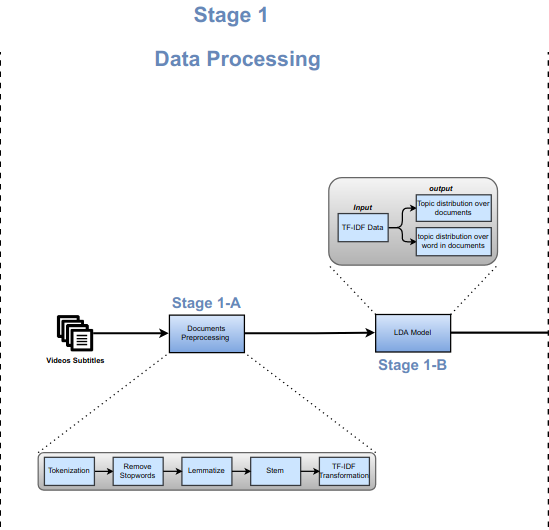

***

### Importing all required libraries.

In [ ]:
from os import listdir
from os.path import isfile, join
import pathlib
import string
import numpy as np
import tqdm
import spacy
import re
# pandas
import pandas as pd
# nltk
import nltk
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords
#gensim
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import CoherenceModel
# pyLDAvis
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

***

<div class="alert alert-info" style="background-color:#cce5ff; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px; color:black; text-align:center;font-size:40px;'>Stage 1-A</h2>
    <br>
    <h2 style='margin:10px 5px; color:black; text-align:center;font-size:40px;'>Data Preprocessing</h2>
</div>

## Reading the data.

In [ ]:
channels = ['techchap', "dave2d", "ijustine", "mkbhd"]

df = pd.DataFrame()
#looping over the channels
for channel in channels:
    #opening the directory of that channel
    files = [f for f in listdir("./Youtube-Data/"+ channel + "/"+ channel + "-subtitles")]
    #looping over the files of channel
    for file in files: 
        try:
            with open (join("./Youtube-Data/"+ channel + "/"+ channel + "-subtitles", file), "r") as myfile:
                data=myfile.read().replace('\n', ' ')
            # clean the data from all punctuation 
            data = data.translate(str.maketrans('', '', string.punctuation))

            tempData = pd.DataFrame([[file, data]])

            df = df.append(tempData, ignore_index=True)
        except:
            print(join("./Youtube-Data/"+ channel + "/"+ channel + "-subtitles", file))

## Viewing the data

In [2]:
df.columns = ["file", "text"]
df

,file,text
0,C12D0TtKqVs.txt,this is going to be a pretty special unboxing ...
1,Vd-SsCiO-g0.txt,hi guys thank you very much for joining me my ...
2,wdt9hrwiaJs.txt,hi guys thank you very much for joining me my ...
3,zONg2dp0rss.txt,hey guys Im Tom a tech job and after four long...
4,qBWnmy_F5N0.txt,I think the love shake circle is one as small ...
...,...,...
4566,K7uLph0s6f0.txt,hey whats up guys how you doing hows done so i...
4567,wUhf0sWhtKw.txt,Music hey whats up guys mkbhd here havent worn...
4568,ay8Ya0DYDYE.txt,Music hey whats up guys MTV HD here back with ...
4569,JUsA_Qy8fXE.txt,hey everyone and welcome to another HT tutoria...


***
<div class="alert alert-info" style="background-color:#cce5ff; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px; color:black;'>Preprocessing pipeline</h2>
</div>

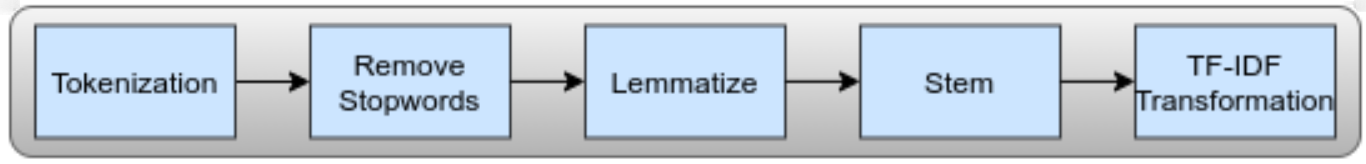

In [5]:
# Convert the titles to lowercase
df['text'] = df['text'].map(lambda x: x.lower())

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_\']')
stemmer = SnowballStemmer('english')

# stopwords from nltk
sw = stopwords.words("english") 

# stopwords from gensim
gensim_stopwords = gensim.parsing.preprocessing.STOPWORDS

# stop words from https://gist.github.com/larsyencken/1440509
stopwords_f_1 = []
with open('stopwords.txt', 'r') as f:
    for word in f:
        word = word.split('\n')
        stopwords_f_1.append(word[0])
        
# stop words from https://countwordsfree.com/stopwords/english        
stopwords_f_2 = []
with open('stop_words_english.txt', 'r') as f:
    for word in f:
        word = word.split('\n')
        stopwords_f_2.append(word[0])        
        
# combining the stopwords collection into one list        
stopwords_collection = list(gensim_stopwords)+stopwords_f_1+sw+stopwords_f_2
# adding more stopwords that we discovered while analyzing the data
stopwords_collection.extend(['guy','hey','ill','bit','hit','fall','ive','set','kay','phd','guys','lot','pretty','people'])
stopwords_collection = set(stopwords_collection)

# stemming function
ps = nltk.PorterStemmer()
def stemming(text_sentence): 
    text = [ps.stem(word) for word in text_sentence.split()]
    return ' '.join(text)

# lemmatizing function
wm = nltk.WordNetLemmatizer()
def lemmatize(text_sentence):
    text = [wm.lemmatize(word) for word in text_sentence.split()]
    return ' '.join(text)

# cleaning the text from special characters and numbers function
def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = re.sub('\d+', '', text)
    return text

# removing the stopwords function
def stopwords_remover(text):
    text = re.sub('\'\w+', '', text) # Remove ticks and the next character 
    text = ' '.join(word for word in text.split() if word not in stopwords_collection) # remove stopwors from text
    return text

# removing the stopwords without punctuation marks
def stopwords_remover_clear(text):
    stopwords_collection_cleaned = [re.compile('[^\w\s]').sub('', i) for i in stopwords_collection]
    text = re.sub('\'\w+', '', text) # Remove ticks and the next character 
    text = ' '.join(word for word in text.split() if word not in stopwords_collection_cleaned) # remove stopwors from text
    return text
<div class="alert alert-info" style="background-color:#cce5ff; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px; color:black;'>Stage 1-A: Data Preprocessing</h2>
</div>
#preprocessing pipeline
def preprocess_text(df):
    df = df.reset_index(drop=True)
    # cleaning the text from special charachters
    df['text'] = df['text'].apply(lambda x : clean_text(x))
    print("cleaned")
    # removing stopwords
    df['text'] = df['text'].apply(lambda x: stopwords_remover(x))
    print("stopwords removed")
    # removing stopwords
    df['text'] = df['text'].apply(lambda x: stopwords_remover_clear(x))
    print("cleaned stopwords removed")
    # lemmatization
    df['text'] = df['text'].apply(lambda x : lemmatize(x))
    print("lemmatized")
    # stemming
    df['text'] = df['text'].apply(lambda x : stemming(x))
    print("stemmig")
    # removing numbers
    df['text'] = df['text'].str.replace('\d+', '')
    print("numbers removed")
    
    return df


## Applying the preprocessing pipeline on the data.

In [6]:
df = preprocess_text(df)
df = df[df['text'].str.len()!=0]

cleaned
stopwords removed
cleaned stopwords removed
lemmatized
stemmig
numbers removed


<ipython-input-5-e71fd9d0a023>:78: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('\d+', '')


In [7]:
df

,file,text
0,C12D0TtKqVs.txt,special unbox brand black box hope box gonna d...
1,Vd-SsCiO-g0.txt,join tom tech jab review samsung galaxi tab in...
2,wdt9hrwiaJs.txt,join tom tech chap video audio comparison cano...
3,zONg2dp0rss.txt,tom tech job appl final updat ipad mini techni...
4,qBWnmy_F5N0.txt,love shake circl cutest secur camera portabl w...
...,...,...
4566,K7uLph0s6f0.txt,week upload video reason shock awe happen luck...
4567,wUhf0sWhtKw.txt,music mkbhd worn shirt store shop mkbhd calm n...
4568,ay8Ya0DYDYE.txt,music mtv hd type video midst galaxi hype smar...
4569,JUsA_Qy8fXE.txt,ht tutori video download instal firefox beta i...


***
<div class="alert alert-info" style="background-color:#cce5ff; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px; color:black;'>TF-IDF Transformation</h2>
</div>

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data = df.text.values.tolist()
data_words = list(sent_to_words(data))

dictionary = gensim.corpora.Dictionary(data_words)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in data_words]

from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus = tfidf[bow_corpus]


***
<div class="alert alert-info" style="background-color:#cce5ff; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px; color:black; text-align:center;font-size:40px;'>Stage 1-B</h2>
    <br>
    <h2 style='margin:10px 5px; color:black; text-align:center;font-size:40px;'>LDA Model</h2>
</div>

### After cleaning the data and transformed it into a tf-idf, we analyzed the topics of the data.

In [16]:
# supporting function to train a model and compute 
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()


***
<div class="alert alert-info" style="background-color:#cce5ff; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px; color:black;'>Training the model</h2>
</div>

In [17]:
# Topics range
min_topics = 1
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
num_of_docs = len(corpus)
corpus_sets = [corpus]
model_results = {'Topics': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=9)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                          k=k)
            # Save the model results
            model_results['Topics'].append(k)
            model_results['Coherence'].append(cv)

            pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_final.csv', index=False)
    pbar.close()


100%|██████████| 9/9 [06:32<00:00, 43.59s/it]


***
<div class="alert alert-info" style="background-color:#cce5ff; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px; color:black;'>Coherence score of each number of topics</h2>
</div>

/home/sad/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


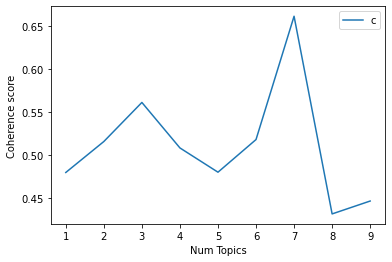

In [27]:
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, pd.read_csv('lda_tuning_results_final.csv')['Coherence'])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## After training alot of models on various number of topics that range from 1 to 300 and trying several language models, we found out that 7 topics with a uni-gram language model gave the best results.
***

### Creating a model with 7 topics

In [20]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=7, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Coherence Score:  0.659889510568225


### Top words of each topic

In [21]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))


Topic: 0 Word: 0.012*"cake" + 0.011*"jenna" + 0.008*"justin" + 0.007*"maddi" + 0.007*"ice" + 0.007*"god" + 0.007*"cook" + 0.006*"cooki" + 0.006*"tast" + 0.006*"egg"
Topic: 1 Word: 0.020*"laptop" + 0.010*"keyboard" + 0.008*"game" + 0.007*"xp" + 0.007*"devic" + 0.006*"perform" + 0.005*"macbook" + 0.005*"cpu" + 0.005*"trackpad" + 0.005*"gpu"
Topic: 2 Word: 0.016*"tutori" + 0.012*"window" + 0.011*"vista" + 0.011*"safari" + 0.010*"firefox" + 0.009*"download" + 0.009*"click" + 0.009*"browser" + 0.008*"instal" + 0.008*"menu"
Topic: 3 Word: 0.000*"dl" + 0.000*"blackberri" + 0.000*"trace" + 0.000*"ray" + 0.000*"rt" + 0.000*"game" + 0.000*"rtx" + 0.000*"laptop" + 0.000*"battlefield" + 0.000*"fp"
Topic: 4 Word: 0.004*"yeti" + 0.002*"yahoo" + 0.001*"talent" + 0.001*"martyr" + 0.001*"pg" + 0.001*"monitor" + 0.001*"tn" + 0.000*"va" + 0.000*"gsync" + 0.000*"ip"
Topic: 5 Word: 0.009*"mous" + 0.008*"mac" + 0.008*"monitor" + 0.008*"pro" + 0.007*"macbook" + 0.007*"laptop" + 0.006*"ipad" + 0.006*"usb" + 0

***
<div class="alert alert-info" style="background-color:#cce5ff; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px; color:black;'>Visualizing the topics</h2>
</div>

In [22]:
pyLDAvis.enable_notebook()
%matplotlib inline

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis


/home/sad/.local/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.028272  0.009598       1        1  75.511455
1     -0.114187 -0.127732       2        1   8.756333
0      0.227098 -0.025895       3        1   5.503444
5     -0.106100 -0.029338       4        1   3.910624
2     -0.059723  0.185251       5        1   3.389984
4      0.040380 -0.006352       6        1   1.469775
3      0.040804 -0.005532       7        1   1.458386, topic_info=        Term       Freq      Total Category  logprob  loglift
578   laptop  98.000000  98.000000  Default  30.0000  30.0000
159      pro  80.000000  80.000000  Default  29.0000  29.0000
320    googl  91.000000  91.000000  Default  28.0000  28.0000
4772   jenna  49.000000  49.000000  Default  27.0000  27.0000
318     game  79.000000  79.000000  Default  26.0000  26.0000
...      ...        ...        ...      ...      ...      ...
187      set   0.119927  33.526945   Topic7  -8.4816  -1.4054
142   oneplu   0.119997  38.615760   Topic7  -8.4810  -1.5461
1246    mous   0.119504  30.424269   Topic7  -8.4852  -1.3118
131    model   0.119537  36.162334   Topic7  -8.4849  -1.4843
291    devic   0.119531  69.288259   Topic7  -8.4849  -2.1346

[457 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2533      2  0.935360     acer
4279      1  0.091322    addon
4279      5  0.821895    addon
530       1  0.751393      air
530       2  0.057799      air
...     ...       ...      ...
525       5  0.107671   youtub
2279      2  0.852824  zenbook
2988      2  0.889877  zephyru
5083      4  0.142400     zune
5083      5  0.712002     zune

[682 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 1, 6, 3, 5, 4])

***

### Saving the model and the dictionary

In [33]:
# Save model to disk.
# temp_file = datapath("./model")
lda_model.save('./model')

#save dictionary to disk
dictionary.save("./dictionary")

/home/sad/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


***
<div class="alert alert-info" style="background-color:#cce5ff; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px; color:black;'>Topic distribution over docutments</h2>
</div>

In [18]:
# Predicting confidence for each document
def predict_conf(row):
    for pred in lda_model[dictionary.doc2bow(row['words'])]:
        row['t{}'.format(pred[0]+1)] = pred[1]
    return row
# copiyng the dataframe
df_video_topic = df.copy()
# adding the tokeniz to the dataframe
df_video_topic['words'] = data_words
# adding columns for each topic
df_video_topic = pd.concat([df_video_topic,pd.DataFrame(columns=['t{}'.format(i) for i in range(1,8)])])
# applying the prediction function
df_video_topic.apply(predict_conf,1)
# removing the unnecessary columns
df_video_topic.drop(columns=['text','words'],inplace=True)
# removing the .txt from the end of each video_id
df_video_topic["file"] = df_video_topic["file"].apply(lambda x: x[:-4])
# renaming the file into video_id
df_video_topic.rename(columns={'file':'video_id'},inplace=True)
df_video_topic.index = [i for i in range(0,4567)]
df_video_topic

/home/sad/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,video_id,t1,t2,t3,t4,t5,t6,t7
0,C12D0TtKqVs,0.00001,0.000010,0.000010,0.00001,0.00001,0.000010,0.997874
1,Vd-SsCiO-g0,0.00001,0.000010,0.000010,0.00001,0.00001,0.000010,0.998692
2,wdt9hrwiaJs,0.00001,0.000010,0.000010,0.00001,0.00001,0.000010,0.995033
3,zONg2dp0rss,0.00001,0.000010,0.000010,0.00001,0.00001,0.403024,0.595146
4,qBWnmy_F5N0,0.00001,0.000010,0.000010,0.00001,0.00001,0.000010,0.996214
...,...,...,...,...,...,...,...,...
4562,K7uLph0s6f0,0.00001,0.000010,0.000010,0.00001,0.00001,0.000010,0.986588
4563,wUhf0sWhtKw,0.00001,0.010404,0.000010,0.00001,0.00001,0.000010,0.988309
4564,ay8Ya0DYDYE,0.00001,0.000010,0.000010,0.00001,0.00001,0.000010,0.998008
4565,JUsA_Qy8fXE,0.00001,0.000010,0.980616,0.00001,0.00001,0.000010,0.016854


### Saving the topic distribution over documents

In [158]:
df_video_topic.to_csv('videos-topics.csv')

/home/sad/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
